# Fashion MNIST CNN + ChatGPT 실습 (TensorFlow + Sequential)

이 실습에서는 TensorFlow의 Sequential API를 사용하여 다층 퍼셉트론(MLP) 모델로 Fashion MNIST 데이터셋을 분류하는 과정을 진행합니다.
Fashion MNIST는 28x28 크기의 흑백 의류 이미지로 구성되어 있으며, 총 10개의 클래스(셔츠, 바지, 신발 등)로 분류됩니다.
우리는 이 데이터를 불러오고, 정규화하며, MLP 모델을 만들고 학습시키며, 성능을 평가하고 예측 결과를 시각화하는 모든 단계를 실습합니다.

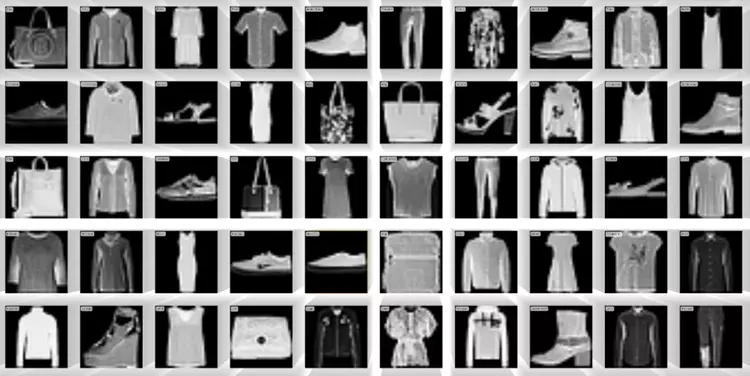

In [ ]:
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

# 설치된 나눔폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 등록
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()

# 기본 폰트 설정
plt.rcParams['font.family'] = nanum_font
plt.rcParams['axes.unicode_minus'] = False

### 프롬프트 1.
###TensorFlow, NumPy, Matplotlib을 활용한 딥러닝 실습을 위해 필요한 라이브러리를 임포트하는 코드 셀을 만들어줘.


In [ ]:
# TensorFlow: 딥러닝 모델 구축 및 학습용
import tensorflow as tf
from tensorflow.keras import layers, models

# NumPy: 수치 계산 및 배열 처리
import numpy as np

# Matplotlib: 시각화
import matplotlib.pyplot as plt

# 버전 확인 (선택 사항)
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.18.0
NumPy version: 2.0.2


### 프롬프트 2.
### Fashion MNIST 데이터를 로드하고, CNN 입력에 맞게 정규화와 reshape을 수행하는 셀을 만들어줘. 입력 형식은 (28, 28, 1)이고, 픽셀은 0~1로 정규화해야 해.


In [ ]:
# Fashion MNIST 데이터 로드
from tensorflow.keras.datasets import fashion_mnist

# 학습용, 테스트용 이미지와 레이블 데이터 불러오기
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# CNN 입력 형식에 맞게 reshape 및 정규화 수행
# CNN은 (높이, 너비, 채널) 형식의 3차원 이미지 입력을 요구
# Fashion MNIST는 흑백 이미지이므로 채널 수는 1 → (28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# 데이터 형태 출력 (모델 입력 확인용)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1), y_test shape: (10000,)


### 프롬프트 3.
### 입력 크기 (28, 28, 1)를 기준으로 하는 간단한 CNN 모델을 Sequential 방식으로 구성해줘. Conv → MaxPooling → Conv → MaxPooling → Flatten → Dense(128) → Dropout(0.3) → Dense(10, softmax) 순서로 만들어줘.


In [ ]:
# CNN 모델 구성에 필요한 레이어 및 모델 모듈 불러오기
from tensorflow.keras import layers, models

# Sequential 모델 생성 (레이어를 순차적으로 쌓는 방식)
model = models.Sequential([
    # 첫 번째 합성곱 레이어
    # 32개의 3x3 필터 사용, ReLU 활성화 함수 적용
    # 입력 이미지 크기는 28x28, 채널 1개 (흑백)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),

    # 최대 풀링 레이어
    # 2x2 영역 중 가장 큰 값만 추출 → 특징 압축 및 계산량 감소
    layers.MaxPooling2D((2, 2)),

    # 두 번째 합성곱 레이어 (필터 수 64개로 증가)
    layers.Conv2D(64, (3, 3), activation='relu'),

    # 두 번째 최대 풀링 레이어
    layers.MaxPooling2D((2, 2)),

    # 특성맵을 1차원으로 펼쳐서 Dense층에 입력할 수 있도록 변환
    layers.Flatten(),

    # 은닉층: 노드 수 128개, ReLU 활성화 함수
    layers.Dense(128, activation='relu'),

    # Dropout: 과적합 방지를 위해 학습 중 일부 뉴런 랜덤 제거 (30%)
    layers.Dropout(0.3),

    # 출력층: 클래스 수 10개 (0~9), 소프트맥스 함수로 확률 출력
    layers.Dense(10, activation='softmax')
])

# 모델 구조 요약 출력 (레이어별 파라미터 수 등 확인 가능)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### 프롬프트 4.
### 앞서 구성한 CNN 모델을 컴파일해줘. 옵티마이저는 'adam', 손실 함수는 'sparse_categorical_crossentropy', 평가지표는 'accuracy'로 해줘.


In [ ]:
# 모델 컴파일: 학습에 필요한 설정을 지정하는 단계
model.compile(
    optimizer='adam',                      # 최적화 알고리즘: Adam (학습 속도 조절 및 수렴에 효과적)
    loss='sparse_categorical_crossentropy',# 손실 함수: 정수형 라벨(y값)을 사용하는 다중 클래스 분류에 적합
    metrics=['accuracy']                   # 평가 지표: 분류 정확도를 기준으로 성능을 확인
)


### 프롬프트 5.
### CNN 모델을 학습하는 코드를 작성해줘. epochs는 5, 검증 데이터로는 전체 훈련 데이터의 10%를 사용하도록 해줘.


In [ ]:
# 모델 학습 시작
history = model.fit(
    x_train,               # 학습에 사용할 입력 이미지 데이터
    y_train,               # 학습에 사용할 실제 정답 레이블

    epochs=5,              # 전체 훈련 데이터셋을 5번 반복 학습 (에폭 수)

    validation_split=0.1,  # 훈련 데이터의 10%를 자동으로 검증 데이터로 분리
                           # → 과적합 여부를 확인하기 위한 평가용 데이터

    verbose=2              # 학습 진행 출력 방식 설정
                           # 0: 출력 없음, 1: 자세히, 2: 간단하게 (에폭당 1줄)
)


Epoch 1/5
1688/1688 - 52s - 31ms/step - accuracy: 0.8120 - loss: 0.5151 - val_accuracy: 0.8662 - val_loss: 0.3585
Epoch 2/5
1688/1688 - 82s - 49ms/step - accuracy: 0.8730 - loss: 0.3476 - val_accuracy: 0.8853 - val_loss: 0.3067
Epoch 3/5
1688/1688 - 81s - 48ms/step - accuracy: 0.8894 - loss: 0.3021 - val_accuracy: 0.8945 - val_loss: 0.2784
Epoch 4/5
1688/1688 - 82s - 49ms/step - accuracy: 0.9006 - loss: 0.2680 - val_accuracy: 0.9035 - val_loss: 0.2603
Epoch 5/5
1688/1688 - 50s - 29ms/step - accuracy: 0.9108 - loss: 0.2433 - val_accuracy: 0.9062 - val_loss: 0.2539


### 프롬프트 6.
### 학습이 완료된 CNN 모델을 테스트 데이터셋으로 평가하고, 테스트 정확도를 출력하는 코드를 만들어줘.


In [ ]:
# 테스트 데이터셋으로 모델 성능 평가
# evaluate() 함수는 [손실 값, 정확도]를 반환함
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# 테스트 정확도 및 손실 출력 (소수점 4자리까지)
print(f"테스트 정확도: {test_accuracy:.4f}")  # 예: 0.8792
print(f"테스트 손실: {test_loss:.4f}")        # 예: 0.3157


테스트 정확도: 0.9051
테스트 손실: 0.2635


## 프롬프트 7.
###CNN 모델이 테스트 이미지 40장을 예측한 결과를 시각화하는 코드 만들어줘. 이미지와 함께 예측값과 실제 정답 라벨을 class 리스트를 활용해 텍스트로 표시하고, 맞으면 파란색, 틀리면 빨간색으로 표시되게 해줘.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


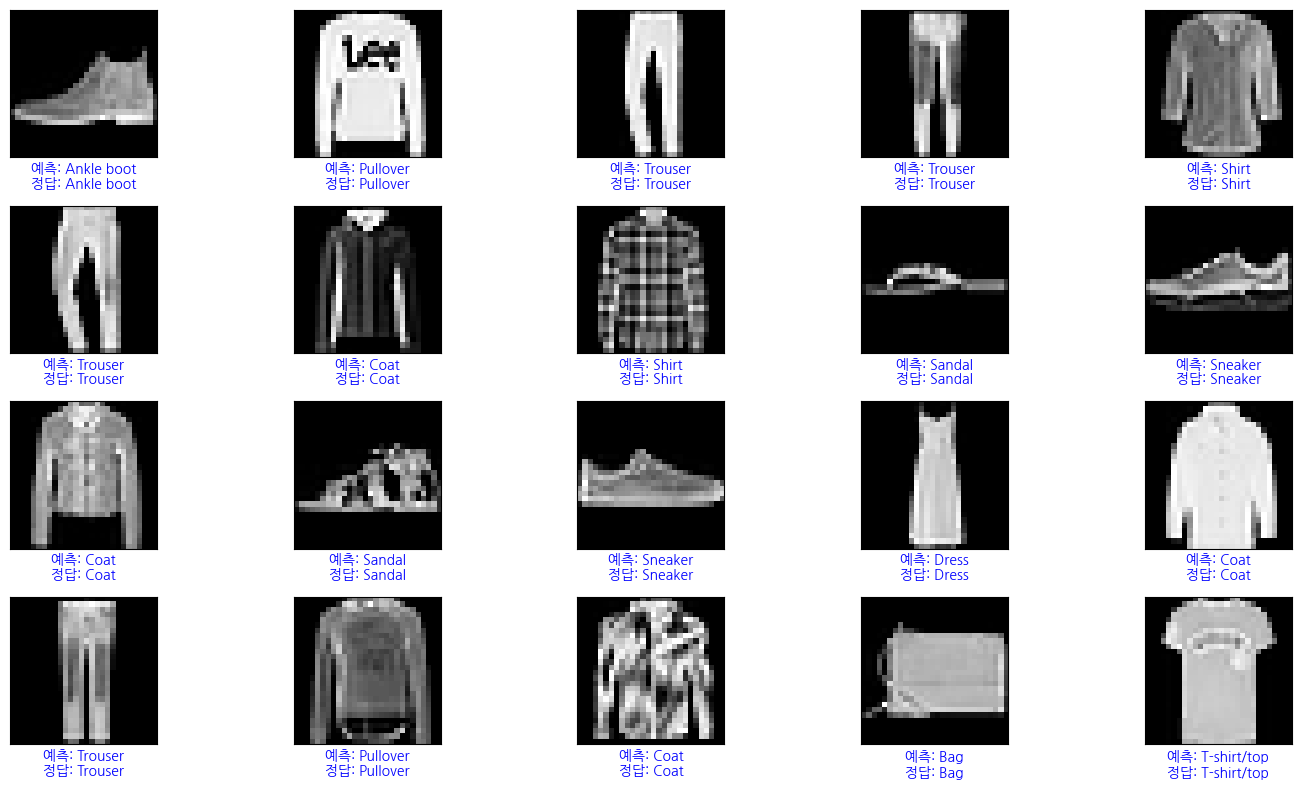

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 클래스 이름 리스트 (Fashion MNIST 기준)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 예측값 계산
predictions = model.predict(x_test)

# 40장 이미지 시각화 (5행 8열)
plt.figure(figsize=(20, 12))
for i in range(40):
    plt.subplot(5, 8, i + 1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)

    pred_label = np.argmax(predictions[i])
    true_label = y_test[i]
    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", color=color)

plt.tight_layout()
plt.show()